In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import diags, eye, kron, csr_matrix
from scipy.sparse.linalg import spsolve
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage import gaussian_filter
from scipy.optimize import curve_fit
import pickle
import netCDF4 as nc

from scipy.interpolate import griddata
from scipy.optimize import minimize_scalar

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


#### ROMS

In [2]:
fname = f'/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'

dataset = nc.Dataset(fname)

lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
mask_rho = np.transpose(dataset.variables['mask_rho'], axes=(1, 0))
h =  np.transpose(dataset.variables['h'], axes=(1, 0))
angle = dataset.variables['angle'][0, 0]
z_r = np.load('/srv/scratch/z5297792/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))[150, 150, :]

def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

j_mid = lon_rho.shape[1] // 2
i_mid = lon_rho.shape[0] // 2

dx = distance(lat_rho[:-1, j_mid], lon_rho[:-1, j_mid],
              lat_rho[1:, j_mid], lon_rho[1:, j_mid])
dy = distance(lat_rho[i_mid, :-1], lon_rho[i_mid, :-1],
              lat_rho[i_mid, 1:], lon_rho[i_mid, 1:])

x_grid = np.insert(np.cumsum(dx), 0, 0)
y_grid = np.insert(np.cumsum(dy), 0, 0)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid, indexing='ij')

with open('/srv/scratch/z5297792/Chapter2/dic_sample.pkl', 'rb') as f:
    dic_sample = pickle.load(f)
sample_eddies = list(dic_sample.keys())

df_eddies = pd.read_pickle("/srv/scratch/z5297792/Chapter2/df_eddies_meso.pkl")


#### Data Extraction

In [3]:
z_r

array([-1.78332027e+00, -5.87962720e+00, -1.07257834e+01, -1.63830966e+01,
       -2.29255808e+01, -3.04441182e+01, -3.90527124e+01, -4.88976380e+01,
       -6.01706386e+01, -7.31278416e+01, -8.81168381e+01, -1.05615538e+02,
       -1.26288127e+02, -1.51065954e+02, -1.81264793e+02, -2.18754856e+02,
       -2.66206398e+02, -3.27440851e+02, -4.07922192e+02, -5.15416489e+02,
       -6.60806374e+02, -8.58918478e+02, -1.12889833e+03, -1.49297118e+03,
       -1.97121252e+03, -2.56867747e+03, -3.25271639e+03, -3.93005327e+03,
       -4.46044702e+03, -4.74891767e+03])

In [4]:
def extract_eddy_domain(eddy, t, dic_sample, df_eddies,
                        mask_rho, X_grid, Y_grid,
                        k=0, radius=200,
                        uv_dir='/srv/scratch/z5297792/Climatology/u_v'):

    eddy = f'Eddy{eddy}'
    day = list(dic_sample[eddy].keys())[t]

    # pull out the snapshot DataFrame
    df_snapshot = dic_sample[eddy][day]

    # figure out which file to load
    sample_id = int(eddy[4:])
    day_num   = int(day[3:])
    row = df_eddies.loc[
        (df_eddies['ID']==sample_id)&
        (df_eddies['Day']==day_num)
    ].iloc[0]
    fname   = row['fname']
    fnumber = fname[-8:-3]

    # load and mask raw u/v
    u_raw = np.load(f'{uv_dir}/u_{fnumber}.npy')
    v_raw = np.load(f'{uv_dir}/v_{fnumber}.npy')
    u_raw = np.where(u_raw>1e30, np.nan, u_raw).astype(float)
    v_raw = np.where(v_raw>1e30, np.nan, v_raw).astype(float)

    # find the time index
    with nc.Dataset(fname) as ds:
        ocean_time = ds.variables['ocean_time'][:].data/86400
        rho = np.transpose(ds.variables['rho'], axes=(3, 2, 1, 0))
        rho = np.flip(rho, axis=2)
    t_rel = np.where(ocean_time==day_num)[0][0]

    # pick out eddy parameters
    data = df_snapshot.iloc[k]
    x0, y0, Q, depth = data.x, data.y, data.Q, data.Depth
    q11, q12, q22    = Q[0,0], Q[1,0], Q[1,1]
    print(f'q11: {q11}, q12: {q12}, q22: {q22}')

    # slice out the k,t_rel snapshot and re‐mask
    u = np.where(mask_rho, u_raw[:,:,k,t_rel], np.nan)
    v = np.where(mask_rho, v_raw[:,:,k,t_rel], np.nan)

    rho = np.squeeze(rho[:,:,:,t_rel])

    # bounding‐box around the eddy centre
    mask_dom = np.hypot(X_grid-x0, Y_grid-y0) <= radius
    i_inds, j_inds = np.where(mask_dom)
    i_min, i_max = i_inds.min(), i_inds.max()
    j_min, j_max = j_inds.min(), j_inds.max()

    # extract the rectangular subarray
    u_eddy = u[i_min:i_max+1, j_min:j_max+1]
    v_eddy = v[i_min:i_max+1, j_min:j_max+1]
    X_eddy = X_grid[i_min:i_max+1, j_min:j_max+1]
    Y_eddy = Y_grid[i_min:i_max+1, j_min:j_max+1]
    x_eddy = X_eddy[:,0]
    y_eddy = Y_eddy[0,:]

    # Density
    rho_eddy = rho[i_min:i_max+1, j_min:j_max+1]
    z_r = np.load('/srv/scratch/z5297792/z_r.npy')
    z_r = -np.transpose(z_r, (1, 2, 0))[i_min:i_max+1, j_min:j_max+1, :]

    return {
        'u': u_eddy,
        'v': v_eddy,
        'X': X_eddy,
        'Y': Y_eddy,
        'x': x_eddy,
        'y': y_eddy,
        'q11': q11,
        'q12': q12,
        'q22': q22,
        'x0': x0,
        'y0': y0,
        'Depth': depth,
        'rho': rho_eddy,
        'z_r': z_r
    }

def extract_transect_center(u, v, X, Y, x0, y0, r=30):

    x, y = X[:,0], Y[0,:]
    
    # find grid point closest to the eddy centre
    dis = np.hypot(X - x0, Y - y0)
    ic, jc = np.unravel_index(np.argmin(dis), dis.shape)

    # horizontal transect (constant y = y[jc])
    x_mask = np.abs(x - x0) < r
    x1 = x[x_mask]
    y1 = np.full_like(x1, y[jc])
    u1 = u[x_mask, jc]
    v1 = v[x_mask, jc]

    # vertical transect (constant x = x[ic])
    y_mask = np.abs(y - y0) < r
    y2 = y[y_mask]
    x2 = np.full_like(y2, x[ic])
    u2 = u[ic, y_mask]
    v2 = v[ic, y_mask]

    # find intersection point
    points1 = set(zip(x1, y1))
    points2 = set(zip(x2, y2))
    common = points1 & points2
    if not common:
        raise ValueError("No common points found.")
    center_x, center_y = common.pop()

    # compute offsets
    xx = x1 - center_x
    yy = y2 - center_y

    return {
        'x1': x1, 'y1': y1, 'u1': u1, 'v1': v1,
        'x2': x2, 'y2': y2, 'u2': u2, 'v2': v2,
        'center_x': center_x, 'center_y': center_y,
        'xx': xx, 'yy': yy
    }

#### Find Rc

In [5]:
def fit_Rc_VN1(x1, y1, v1, q11, q12, q22, x0, y0,
           scale0=1.0, Rc0=1.0,
           bounds_scale=(-np.inf, np.inf), bounds_Rc=(.5, 15)):
    from scipy.optimize import minimize

    q11, q22 = np.abs(q11), np.abs(q22)

    # relative transect offset
    y_T = y1[0]

    def obj(p):
        scale, Rc = p
        if Rc <= 0:
            return np.inf

        # build un‐scaled quadratic
        C = q11
        B = -2*q11*x0 + 2*q12*(y_T-y0)
        E = q11*x0**2 - 2*q12*x0*(y_T-y0) + q22*(y_T-y0)**2

        # modelled V_N
        expo = -(C*x1**2 + B*x1 + E) / Rc**2
        VN = -(2*C*x1 + B) / Rc**2 * np.exp(expo) * scale

        return np.sum((v1 - VN)**2)

    p0 = np.array([scale0, Rc0])

    res = minimize(obj, p0,
                   bounds=[bounds_scale, bounds_Rc],
                   method='L-BFGS-B')
    if not res.success:
        raise RuntimeError("Optimization failed: " + res.message)

    return res.x  # scale_opt, Rc_opt

def fit_Rc_VT1(x1, y1, u1, q11, q12, q22, x0, y0,
           scale0=1.0, Rc0=1.0,
           bounds_scale=(-np.inf, np.inf), bounds_Rc=(.5, 15)):
    from scipy.optimize import minimize

    q11, q22 = np.abs(q11), np.abs(q22)

    # relative transect offset
    y_T = y1[0]

    def obj(p):
        scale, Rc = p
        if Rc <= 0:
            return np.inf

        # build un‐scaled quadratic
        F = -2*q12
        G = 2*q12*x0 - 2*q22*(y_T-y0)
        C = q11
        D = -2*q11*x0 + 2*q12*(y_T-y0)
        E = q11*x0**2 - 2*q12*x0*(y_T-y0) + q22*(y_T-y0)**2

        # modelled V_N
        expo = -(C*x1**2 + D*x1 + E) / Rc**2
        VT = -(F*x1 + G) / Rc**2 * np.exp(expo) * scale

        return np.sum((u1 - VT)**2)

    p0 = np.array([scale0, Rc0])

    res = minimize(obj, p0,
                   bounds=[bounds_scale, bounds_Rc],
                   method='L-BFGS-B')
    if not res.success:
        raise RuntimeError("Optimization failed: " + res.message)

    return res.x  # scale_opt, Rc_opt

def fit_Rc_VN2(x2, y2, u2, q11, q12, q22, x0, y0,
           scale0=1.0, Rc0=1.0,
           bounds_scale=(-np.inf, np.inf), bounds_Rc=(.5, 15)):
    from scipy.optimize import minimize

    q11, q22 = np.abs(q11), np.abs(q22)

    # relative transect offset
    x_T = x2[0]

    def obj(p):
        scale, Rc = p
        if Rc <= 0:
            return np.inf

        # build un‐scaled quadratic
        C = q22
        B = 2*y0*q22 - 2*q12*(x_T-x0)
        E = q11*(x_T-x0)**2 - 2*q12*(x_T-x0)*y0 + q22*y0**2

        # modelled V_N
        expo = -(C*y2**2 - B*y2 + E) / Rc**2
        VN = -(-2*C*y2 + B) / Rc**2 * np.exp(expo) * scale

        return np.sum((u2 - VN)**2)

    p0 = np.array([scale0, Rc0])

    res = minimize(obj, p0,
                   bounds=[bounds_scale, bounds_Rc],
                   method='L-BFGS-B')
    if not res.success:
        raise RuntimeError("Optimization failed: " + res.message)

    return res.x  # scale_opt, Rc_opt

def fit_Rc_VT2(x2, y2, v2, q11, q12, q22, x0, y0,
           scale0=1.0, Rc0=1.0,
           bounds_scale=(-np.inf, np.inf), bounds_Rc=(.5, 15)):
    from scipy.optimize import minimize

    q11, q22 = np.abs(q11), np.abs(q22)

    # relative transect offset
    x_T = x2[0]

    def obj(p):
        scale, Rc = p
        if Rc <= 0:
            return np.inf

        # build un‐scaled quadratic
        F = 2*q12
        G = 2*q11*(x_T-x0) - 2*q12*y0
        C = q22
        D = 2*q12*(x_T-x0) - 2*y0*q22
        E = q11*(x_T-x0)**2 - 2*q12*(x_T-x0)*y0 + q22*y0**2

        # modelled V_N
        expo = -(C*y2**2 + D*y2 + E) / Rc**2
        VT = -(F*y2 + G) / Rc**2 * np.exp(expo) * scale

        return np.sum((v2 - VT)**2)

    p0 = np.array([scale0, Rc0])

    res = minimize(obj, p0,
                   bounds=[bounds_scale, bounds_Rc],
                   method='L-BFGS-B')
    if not res.success:
        raise RuntimeError("Optimization failed: " + res.message)

    return res.x  # scale_opt, Rc_opt
    

In [6]:
df = pd.DataFrame(columns=['Cyc'])
for eddy in sample_eddies:
    eddy = int(eddy[4:])
    cyc = df_eddies[df_eddies['ID']==eddy].iloc[0]['Cyc']
    df.loc[len(df)] = {'Cyc': cyc}
df.index = sample_eddies
df


,Cyc
Eddy2749,AE
Eddy8,AE
Eddy2504,AE
Eddy896,AE
Eddy1394,CE
Eddy382,CE
Eddy1967,CE
Eddy926,CE


In [7]:
eddy = 1967
t = 10

dic_eddy_domain = extract_eddy_domain(eddy, t, dic_sample, df_eddies, mask_rho, X_grid, Y_grid)
ue = dic_eddy_domain['u']
ve = dic_eddy_domain['v']
Xe = dic_eddy_domain['X']
Ye = dic_eddy_domain['Y']
q11e = dic_eddy_domain['q11']
q12e = dic_eddy_domain['q12']
q22e = dic_eddy_domain['q22']
x0e = dic_eddy_domain['x0']
y0e = dic_eddy_domain['y0']
Depthe = dic_eddy_domain['Depth']

dic_eddy_transect = extract_transect_center(ue, ve, Xe, Ye, x0e, y0e, r=60)
x1e = dic_eddy_transect['x1']
y1e = dic_eddy_transect['y1']
u1e = dic_eddy_transect['u1']
v1e = dic_eddy_transect['v1']
xxe = dic_eddy_transect['xx']
x2e = dic_eddy_transect['x2']
y2e = dic_eddy_transect['y2']
u2e = dic_eddy_transect['u2']
v2e = dic_eddy_transect['v2']
yye = dic_eddy_transect['yy']

scale_VN1e, Rc_VN1e = fit_Rc_VN1(x1e, y1e, v1e, q11e, q12e, q22e, x0e, y0e)
scale_VT1e, Rc_VT1e = fit_Rc_VT1(x1e, y1e, u1e, q11e, q12e, q22e, x0e, y0e)

scale_VN2e, Rc_VN2e = fit_Rc_VN2(x2e, y2e, u2e, q11e, q12e, q22e, x0e, y0e)
scale_VT2e, Rc_VT2e = fit_Rc_VT2(x2e, y2e, v2e, q11e, q12e, q22e, x0e, y0e)

df_Rce = pd.DataFrame({'Rc': [Rc_VN1e, Rc_VT1e, Rc_VN2e, Rc_VT2e], 'Scale': [scale_VN1e, scale_VT1e, scale_VN2e, scale_VT2e]})
df_Rce.index = [r'$V_{N1}$', r'$V_{T1}$', r'$V_{N2}$', r'$V_{T2}$']

Rce = min(df_Rce.iloc[0]['Rc'], df_Rce.iloc[2]['Rc'])
scale_opt = df_Rce[df_Rce['Rc']==Rce].iloc[0]['Scale']
df_Rce


q11: -0.008418143656544594, q12: -0.000479935766615009, q22: -0.007305326419901507


,Rc,Scale
$V_{N1}$,5.709967,32.704974
$V_{T1}$,0.772482,0.810050
$V_{N2}$,6.440933,36.476138
$V_{T2}$,1.437242,2.199119


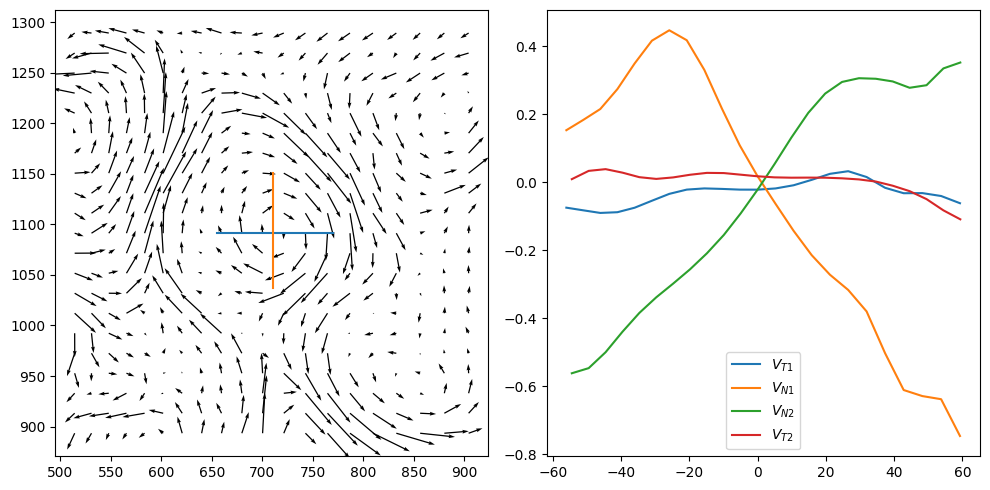

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))

spacing = 4
quiv_scale = 10
axs[0].quiver(Xe[::spacing, ::spacing], Ye[::spacing, ::spacing], ue[::spacing, ::spacing], ve[::spacing, ::spacing],
             scale=quiv_scale)
axs[0].plot(x1e, y1e)
axs[0].plot(x2e, y2e)
axs[0].axis('equal')

axs[1].plot(xxe, u1e, label=r'$V_{T1}$')
axs[1].plot(xxe, v1e, label=r'$V_{N1}$')
axs[1].plot(yye, u2e, label=r'$V_{N2}$')
axs[1].plot(yye, v2e, label=r'$V_{T2}$')
axs[1].legend()

plt.tight_layout()
plt.show()

In [9]:
def gaussian_vel_reconstruction(x0, y0, q11, q12, q22, R, scale_opt):

    q11, q22 = np.abs(q11), np.abs(q22)
    
    width = 200
    x = np.linspace(x0-width, x0+width, 51)
    y = np.linspace(y0-width, y0+width, 51)
    X, Y = np.meshgrid(x, y)
    
    dx, dy = X - x0, Y - y0
    
    phi   = q11*dx**2 + 2*q12*dx*dy + q22*dy**2
    phi_x = 2*q11*dx  + 2*q12*dy
    phi_y = 2*q22*dy  + 2*q12*dx
    
    # 5) build Gaussian streamfunction with that R
    exp_term = np.exp(-phi / R**2)
    psi_x = -phi_x / R**2 * exp_term
    psi_y = -phi_y / R**2 * exp_term
    
    u = -psi_y * scale_opt
    v =  psi_x * scale_opt

    return u, v, X, Y

u_dopioe, v_dopioe, X_dopioe, Y_dopioe = gaussian_vel_reconstruction(x0e, y0e, q11e, q12e, q22e, Rce, scale_opt)


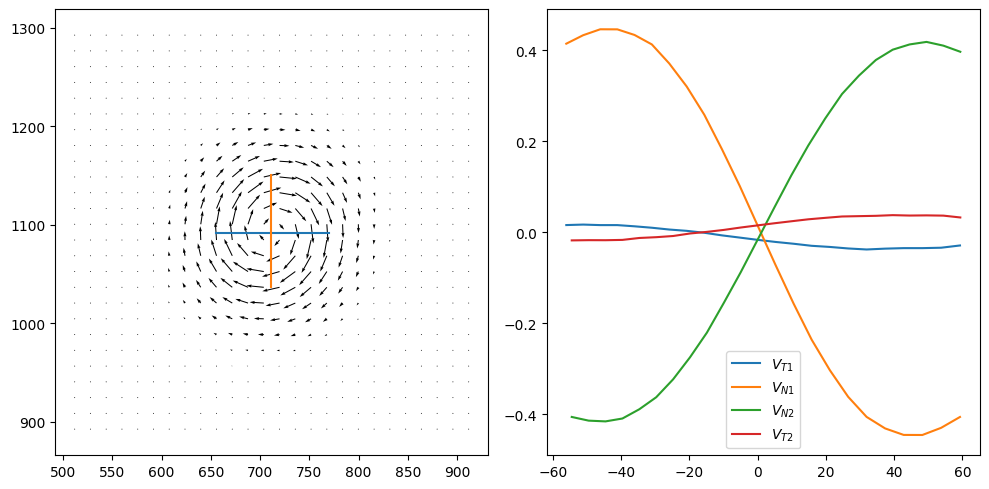

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))

spacing = 2
quiv_scale = 10
axs[0].quiver(X_dopioe[::spacing, ::spacing], Y_dopioe[::spacing, ::spacing], u_dopioe[::spacing, ::spacing], v_dopioe[::spacing, ::spacing],
             scale=quiv_scale)
axs[0].plot(x1e, y1e)
axs[0].plot(x2e, y2e)
axs[0].axis('equal')

points = np.column_stack((X_dopioe.ravel(), Y_dopioe.ravel()))
values_v, values_u = v_dopioe.ravel(), u_dopioe.ravel()
v1_dopioe = griddata(points, values_v, (x1e, y1e), method='linear')
u1_dopioe = griddata(points, values_u, (x1e, y1e), method='linear')
v2_dopioe = griddata(points, values_v, (x2e, y2e), method='linear')
u2_dopioe = griddata(points, values_u, (x2e, y2e), method='linear')

axs[1].plot(xxe, u1_dopioe, label=r'$V_{T1}$')
axs[1].plot(xxe, v1_dopioe, label=r'$V_{N1}$')
axs[1].plot(yye, u2_dopioe, label=r'$V_{N2}$')
axs[1].plot(yye, v2_dopioe, label=r'$V_{T2}$')
axs[1].legend()

plt.tight_layout()
plt.show()

In [11]:
eddy = 1967
t = 10

In [12]:
# for eddy in sample_eddies:
#     eddy = int(eddy[4:])

eddy = 1967
t = 10
df_Rc = pd.DataFrame(columns=['Rc', 'Scale', 'Depth'])
dic = {}
for k in range(23):
    dic[f'z{k}'] = {}
    dic_eddy_domain = extract_eddy_domain(eddy, t, dic_sample, df_eddies, mask_rho, X_grid, Y_grid, k=k)
    ue = dic_eddy_domain['u']
    ve = dic_eddy_domain['v']
    Xe = dic_eddy_domain['X']
    Ye = dic_eddy_domain['Y']
    q11e = dic_eddy_domain['q11']
    q12e = dic_eddy_domain['q12']
    q22e = dic_eddy_domain['q22']
    x0e = dic_eddy_domain['x0']
    y0e = dic_eddy_domain['y0']
    Depthe = dic_eddy_domain['Depth']
    
    dic_eddy_transect = extract_transect_center(ue, ve, Xe, Ye, x0e, y0e, r=60)
    x1e = dic_eddy_transect['x1']
    y1e = dic_eddy_transect['y1']
    u1e = dic_eddy_transect['u1']
    v1e = dic_eddy_transect['v1']
    xxe = dic_eddy_transect['xx']
    x2e = dic_eddy_transect['x2']
    y2e = dic_eddy_transect['y2']
    u2e = dic_eddy_transect['u2']
    v2e = dic_eddy_transect['v2']
    yye = dic_eddy_transect['yy']
    
    scale_VN1e, Rc_VN1e = fit_Rc_VN1(x1e, y1e, v1e, q11e, q12e, q22e, x0e, y0e)
    scale_VT1e, Rc_VT1e = fit_Rc_VT1(x1e, y1e, u1e, q11e, q12e, q22e, x0e, y0e)
    
    scale_VN2e, Rc_VN2e = fit_Rc_VN2(x2e, y2e, u2e, q11e, q12e, q22e, x0e, y0e)
    scale_VT2e, Rc_VT2e = fit_Rc_VT2(x2e, y2e, v2e, q11e, q12e, q22e, x0e, y0e)
    
    df_Rce = pd.DataFrame({'Rc': [Rc_VN1e, Rc_VT1e, Rc_VN2e, Rc_VT2e], 'Scale': [scale_VN1e, scale_VT1e, scale_VN2e, scale_VT2e]})
    df_Rce.index = [r'$V_{N1}$', r'$V_{T1}$', r'$V_{N2}$', r'$V_{T2}$']
    Rce = min(df_Rce.iloc[0]['Rc'], df_Rce.iloc[2]['Rc'])
    scale_opt = df_Rce[df_Rce['Rc']==Rce].iloc[0]['Scale']

    df_Rc.loc[len(df_Rc)] = {'Rc': Rce, 'Scale': scale_opt, 'Depth': Depthe}

    u_dopioe, v_dopioe, X_dopioe, Y_dopioe = gaussian_vel_reconstruction(x0e, y0e, q11e, q12e, q22e, Rce, scale_opt)
    dic[f'z{k}']['u'] = u_dopioe
    dic[f'z{k}']['v'] = v_dopioe
    dic[f'z{k}']['X'] = X_dopioe
    dic[f'z{k}']['Y'] = Y_dopioe
    dic[f'z{k}']['Depth'] = z_r[k]

df_Rc


q11: -0.008418143656544594, q12: -0.000479935766615009, q22: -0.007305326419901507
q11: -0.008285623241885497, q12: -0.0003726952898278265, q22: -0.007494234853662745
q11: -0.007824457270776446, q12: -0.0006860148399992193, q22: -0.007307966478212771
q11: -0.0076171495866252294, q12: -0.0007369138588126854, q22: -0.007262103396722901
q11: -0.007367482961443314, q12: -0.0007492268312024904, q22: -0.007080434806506334
q11: -0.007066734728090202, q12: -0.0007053779768730945, q22: -0.006573175309051117
q11: -0.006972477072269749, q12: -0.0005932824260102876, q22: -0.0064099386397199285
q11: -0.007326777624852041, q12: -0.0008201017946835248, q22: -0.0064834260155066355
q11: -0.007299140044968177, q12: -0.00041007984544231657, q22: -0.006549413167757558
q11: -0.007105046948196286, q12: -0.00047474781252059104, q22: -0.006281639542087276
q11: -0.006889345947558882, q12: -0.0004911922223061392, q22: -0.00593410671775711
q11: -0.00658719844598145, q12: -0.0005368031046767028, q22: -0.005483833

,Rc,Scale,Depth
0,5.709967,32.704974,-1.783320
1,5.144907,29.921873,-5.879627
2,5.336242,33.081488,-10.725783
3,6.384241,44.143044,-16.383097
4,5.946391,41.193628,-22.925581
5,5.609549,39.274483,-30.444118
6,5.536369,38.102036,-39.052712
7,5.837068,38.944936,-48.897638
8,5.838984,38.217409,-60.170639
9,5.781776,37.489996,-73.127842


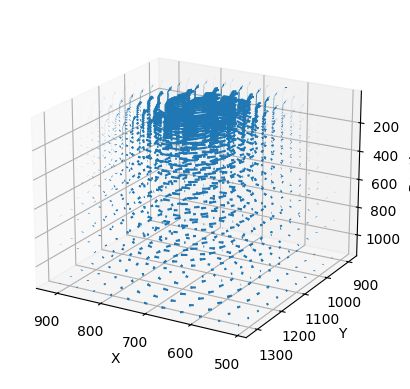

In [13]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

spacing = 5
scale_factor = 100  # adjust arrow length

for key in dic:
    d = dic[key]
    XX = d['X'][::spacing, ::spacing]
    YY = d['Y'][::spacing, ::spacing]
    ZZ = -d['Depth']
    UU = d['u'][::spacing, ::spacing] * scale_factor
    VV = d['v'][::spacing, ::spacing] * scale_factor
    WW = np.zeros_like(UU)

    ax.quiver(XX, YY, ZZ, UU, VV, WW)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Depth')
ax.invert_zaxis()
ax.view_init(elev=20, azim=120)

plt.show()



### Generate Gridded Velocity Field

In [14]:
import numpy as np
from scipy.interpolate import griddata

# 1) collect all (x,y,z) points and their u,v values
pts = []
uvals = []
vvals = []
for d in dic.values():
    X = d['X'].ravel()
    Y = d['Y'].ravel()
    Z = -d['Depth'] * np.ones_like(X)
    pts.append(np.column_stack((X, Y, Z)))
    uvals.append((d['u'] * scale_factor).ravel())
    vvals.append((d['v'] * scale_factor).ravel())

pts   = np.vstack(pts)
uvals = np.concatenate(uvals)
vvals = np.concatenate(vvals)

# 2) choose your new grid resolution
nz = len(dic)
ny = max(d['X'].shape[0] for d in dic.values()) // 2 # Halve Resolution
nx = max(d['X'].shape[1] for d in dic.values()) // 2

xi = np.linspace(pts[:,0].min(), pts[:,0].max(), nx)
yi = np.linspace(pts[:,1].min(), pts[:,1].max(), ny)
# zi = np.linspace(pts[:,2].min(), pts[:,2].max(), nz)
zi = -z_r[:np.sort([int(a[1:]) for a in dic.keys()]).max()+1]

Xg, Yg, Zg = np.meshgrid(xi, yi, zi, indexing='xy')
grid_pts   = np.column_stack((Xg.ravel(), Yg.ravel(), Zg.ravel()))

# 3) interpolate onto the cube
U = griddata(pts, uvals, grid_pts, method='linear', fill_value=0)
V = griddata(pts, vvals, grid_pts, method='linear', fill_value=0)
# W = np.zeros_like(U)

# 4) reshape back to 3D
U = U.reshape(Xg.shape)
V = V.reshape(Xg.shape)
# W = W.reshape(Xg.shape)


#### N2

In [15]:
def compute_N2(rho, Zg, g=9.81, rho0=1025):
    """
    Compute buoyancy frequency squared (N^2) for a 3D density field rho(x, y, z)
    using the true vertical coordinate Zg(x, y, z).
    """

    # Get vertical derivative ∂ρ/∂z using chain rule ∂ρ/∂Zg
    drho_dz = np.empty_like(rho)
    
    for k in range(1, rho.shape[2] - 1):
        dz = Zg[:, :, k+1] - Zg[:, :, k-1]
        drho = rho[:, :, k+1] - rho[:, :, k-1]
        drho_dz[:, :, k] = drho / dz

    # Forward/backward difference at boundaries
    drho_dz[:, :, 0] = (rho[:, :, 1] - rho[:, :, 0]) / (Zg[:, :, 1] - Zg[:, :, 0])
    drho_dz[:, :, -1] = (rho[:, :, -1] - rho[:, :, -2]) / (Zg[:, :, -1] - Zg[:, :, -2])

    # Compute N²
    N2 = - (g / rho0) * drho_dz  # Units: s⁻²
    return N2

rho = dic_eddy_domain['rho']
zr = dic_eddy_domain['z_r']
x = dic_eddy_domain['x']
y = dic_eddy_domain['y']

N2 = compute_N2(rho, zr)


In [16]:
from scipy.interpolate import griddata

# --- original data: 
# x.shape = (nx,), y.shape = (ny,), 
# zr.shape = N2.shape = (nx, ny, nz)

# make a list of (x,y,zr) triples and flatten N2
Xgg = np.broadcast_to(x[:,None,None], zr.shape)
Ygg = np.broadcast_to(y[None,:,None], zr.shape)
pts = np.column_stack((Xgg.ravel(), Ygg.ravel(), zr.ravel()))
vals = N2.ravel()

# --- target grid:
# xi.shape = (nxi,), yi.shape = (nyi,), zi.shape = (nzi,)
Xi, Yi, Zi = np.meshgrid(xi, yi, zi, indexing='ij')
pts_new = np.column_stack((Xi.ravel(), Yi.ravel(), Zi.ravel()))

# linear 3D interpolation
N2_new = griddata(pts, vals, pts_new, method='linear')
N2_new = N2_new.reshape(Xi.shape)



In [44]:
N2_new = - N2_new

/scratch/pbs.6546176.kman.restech.unsw.edu.au/ipykernel_2253479/1698256558.py:2: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


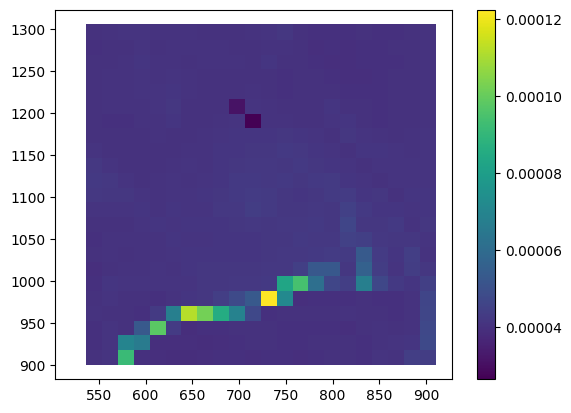

In [45]:
plt.pcolor(xi, yi, N2_new[:,:,2])
plt.colorbar()

In [37]:
N2_new.shape

(25, 25, 23)

In [38]:
np.nanmean(N2_new, axis=(0,1))

array([-3.83266975e-05, -3.99963833e-05, -4.23638135e-05, -4.41649559e-05,
       -4.54369064e-05, -4.65127280e-05, -4.77364383e-05, -4.88612674e-05,
       -4.95399977e-05, -4.93102206e-05, -4.91720415e-05, -4.97235200e-05,
       -5.16070589e-05, -5.61270244e-05, -6.59348191e-05, -7.87285683e-05,
       -8.46830525e-05, -8.05024667e-05, -7.15854924e-05, -6.30057501e-05,
       -5.66036999e-05, -5.28679911e-05, -5.07114504e-05])

#### G-Q Equation

In [21]:
# def solve_w(U, V, x, y, z, f=-7.7e-5, N2=5e-3):
#     # tic = time.time()

#     x = x * 1000
#     y = y * 1000
#     z = z * 1000

#     dx, dy = x[1] - x[0], y[1] - y[0]
#     nx, ny, nz = U.shape

#     # build Q
#     dudz = np.gradient(U, z, axis=2)
#     dvdz = np.gradient(V, z, axis=2)
#     dvdx = np.gradient(V, dx, axis=0)
#     dvdy = np.gradient(V, dy, axis=1)
#     dudx = np.gradient(U, dx, axis=0)
#     dudy = np.gradient(U, dy, axis=1)

#     Qx =  f * (dudz * dvdx + dvdz * dvdy)
#     Qy = -f * (dudz * dudx + dvdz * dudy)

#     S = 2 * (np.gradient(Qx, dx, axis=0) + np.gradient(Qy, dy, axis=1))
#     b = S.ravel(order='F')

#     # finite difference operators
#     ex, ey = np.ones(nx), np.ones(ny)
#     Lx = diags([ex, -2*ex, ex], [-1, 0, 1], shape=(nx, nx)) / dx**2
#     Ly = diags([ey, -2*ey, ey], [-1, 0, 1], shape=(ny, ny)) / dy**2
#     Ix, Iy = eye(nx), eye(ny)

#     # nonuniform Lz
#     Lz = np.zeros((nz, nz))
#     for i in range(1, nz - 1):
#         dzm = z[i] - z[i - 1]
#         dzp = z[i + 1] - z[i]
#         Lz[i, i - 1] =  2 / (dzm * (dzm + dzp))
#         Lz[i, i]     = -2 / (dzm * dzp)
#         Lz[i, i + 1] =  2 / (dzp * (dzm + dzp))
#     Lz = csr_matrix(Lz)
#     Iz = eye(nz)

#     A = N2 * (kron(kron(Iz, Iy), Lx) + kron(kron(Iz, Ly), Ix)) \
#       + f**2 * kron(kron(Lz, Iy), Ix)

#     w = spsolve(A.tocsr(), b).reshape((nx, ny, nz), order='F')

#     # toc = time.time()
#     # print(f"Elapsed time: {toc - tic:.4f} seconds")

#     return w


In [22]:
import numpy as np
from scipy.sparse import diags, eye, csr_matrix, kron
from scipy.sparse.linalg import spsolve

def solve_w(U, V, x, y, z, f=-7.7e-5, N2=5e-3):
    """
    Solve ∇_H^2(N2(z)*w) + f^2 ∂²w/∂z² = 2 ∇_H·Q for w.
    
    U, V : 3D arrays, shape (nx, ny, nz)
    x, y, z : 1D coords (in km) -> will be converted to m
    f : Coriolis parameter
    N2 : either scalar or 1D array of length nz (buoyancy freq² profile)
    """
    # convert km → m
    x = x * 1e3
    y = y * 1e3
    z = z * 1e3

    dx, dy = x[1] - x[0], y[1] - y[0]
    nx, ny, nz = U.shape

    # --- build the RHS b = 2 ∇_H·Q ---
    dudz = np.gradient(U, z, axis=2)
    dvdz = np.gradient(V, z, axis=2)
    dvdx = np.gradient(V, dx, axis=0)
    dvdy = np.gradient(V, dy, axis=1)
    dudx = np.gradient(U, dx, axis=0)
    dudy = np.gradient(U, dy, axis=1)

    Qx =  f * (dudz * dvdx + dvdz * dvdy)
    Qy = -f * (dudz * dudx + dvdz * dudy)

    S = 2 * (np.gradient(Qx, dx, axis=0) + np.gradient(Qy, dy, axis=1))
    b = S.ravel(order='F')

    # --- finite-difference operators ---
    ex, ey = np.ones(nx), np.ones(ny)
    Lx = diags([ex, -2*ex, ex], [-1, 0, 1], shape=(nx, nx)) / dx**2
    Ly = diags([ey, -2*ey, ey], [-1, 0, 1], shape=(ny, ny)) / dy**2
    Ix, Iy = eye(nx), eye(ny)

    # non-uniform vertical second derivative
    Lz = np.zeros((nz, nz))
    for k in range(1, nz-1):
        dzm = z[k] - z[k-1]
        dzp = z[k+1] - z[k]
        Lz[k, k-1] =  2/(dzm*(dzm+dzp))
        Lz[k, k  ] = -2/(dzm*dzp)
        Lz[k, k+1] =  2/(dzp*(dzm+dzp))
    Lz = csr_matrix(Lz)
    Iz = eye(nz)

    # --- handle N2: scalar → constant profile; 1D → layer profile ---
    N2_arr = np.atleast_1d(N2)
    if N2_arr.ndim == 0:
        N2_vec = np.full(nz, float(N2_arr))
    elif N2_arr.ndim == 1 and N2_arr.size == nz:
        N2_vec = N2_arr
    else:
        raise ValueError("N2 must be scalar or 1D array of length nz")

    # build the variable-stratification horizontal operator:
    #  ∇_H^2(N2(z) w) → diag(N2_vec) in z ⊗ (Ly ⊗ Ix + Iy ⊗ Lx)
    N2_diag = diags(N2_vec, 0)
    Hx = kron(kron(N2_diag, Iy), Lx)
    Hy = kron(kron(N2_diag, Ly), Ix)
    Hvar = Hx + Hy

    # full operator
    A = Hvar + f**2 * kron(kron(Lz, Iy), Ix)

    # solve and reshape
    w = spsolve(A.tocsr(), b)
    return w.reshape((nx, ny, nz), order='F')


In [23]:
# from scipy.sparse import diags, eye, csr_matrix, kron
# from scipy.sparse.linalg import spsolve

# def solve_w(U, V, x, y, z, f=-7.7e-5, N2=5e-3):
#     """
#     Solve ∇_H²(N2(x,y,z)·w) + f² ∂²w/∂z² = 2 ∇_H·Q
#     allowing N2 to be scalar or a 3D field of shape U.shape.
#     """
#     #— convert km → m
#     x = x * 1e3
#     y = y * 1e3
#     z = z * 1e3

#     dx, dy = x[1] - x[0], y[1] - y[0]
#     nx, ny, nz = U.shape

#     #— build RHS b = 2 ∇_H·Q
#     dudz = np.gradient(U, z, axis=2)
#     dvdz = np.gradient(V, z, axis=2)
#     dvdx = np.gradient(V, dx, axis=0)
#     dvdy = np.gradient(V, dy, axis=1)
#     dudx = np.gradient(U, dx, axis=0)
#     dudy = np.gradient(U, dy, axis=1)

#     Qx =  f * (dudz * dvdx + dvdz * dvdy)
#     Qy = -f * (dudz * dudx + dvdz * dudy)

#     S = 2*(np.gradient(Qx, dx, axis=0) + np.gradient(Qy, dy, axis=1))
#     b = S.ravel(order='F')

#     #— finite-difference operators
#     ex, ey = np.ones(nx), np.ones(ny)
#     Lx = diags([ ex, -2*ex,  ex], [-1,0,1], shape=(nx,nx)) / dx**2
#     Ly = diags([ ey, -2*ey,  ey], [-1,0,1], shape=(ny,ny)) / dy**2
#     Ix, Iy = eye(nx), eye(ny)

#     #— vertical second-derivative (nonuniform)
#     Lz = np.zeros((nz,nz))
#     for k in range(1, nz-1):
#         dzm = z[k]   - z[k-1]
#         dzp = z[k+1] - z[k]
#         Lz[k, k-1] =  2/(dzm*(dzm+dzp))
#         Lz[k, k  ] = -2/(dzm*dzp)
#         Lz[k, k+1] =  2/(dzp*(dzm+dzp))
#     Lz = csr_matrix(Lz)
#     Iz = eye(nz)

#     #— handle N2 input
#     if np.isscalar(N2):
#         N2_flat = float(N2) * np.ones(U.size)
#     elif isinstance(N2, np.ndarray) and N2.shape == U.shape:
#         N2_flat = N2.ravel(order='F')
#     else:
#         raise ValueError("N2 must be scalar or a 3D array matching U.shape")

#     #— horizontal Laplacian operator H0
#     H0 = kron(kron(Iz, Iy), Lx) + kron(kron(Iz, Ly), Ix)

#     #— build A = H0·diag(N2) + f²·(Lz⊗Iy⊗Ix)
#     A_h = H0.dot(diags(N2_flat, 0))
#     A_v = f**2 * kron(kron(Lz, Iy), Ix)
#     A   = (A_h + A_v).tocsr()

#     #— solve and reshape
#     w_flat = spsolve(A, b)
#     return w_flat.reshape((nx, ny, nz), order='F')


In [39]:
np.nanmean(N2_new, axis=(0,1))

array([-3.83266975e-05, -3.99963833e-05, -4.23638135e-05, -4.41649559e-05,
       -4.54369064e-05, -4.65127280e-05, -4.77364383e-05, -4.88612674e-05,
       -4.95399977e-05, -4.93102206e-05, -4.91720415e-05, -4.97235200e-05,
       -5.16070589e-05, -5.61270244e-05, -6.59348191e-05, -7.87285683e-05,
       -8.46830525e-05, -8.05024667e-05, -7.15854924e-05, -6.30057501e-05,
       -5.66036999e-05, -5.28679911e-05, -5.07114504e-05])

In [46]:
W = solve_w(U, V, xi, yi, zi, N2=[5e-3]*23)

# W = solve_w(U, V, xi, yi, zi, N2=np.nanmean(N2_new, axis=(0,1)))


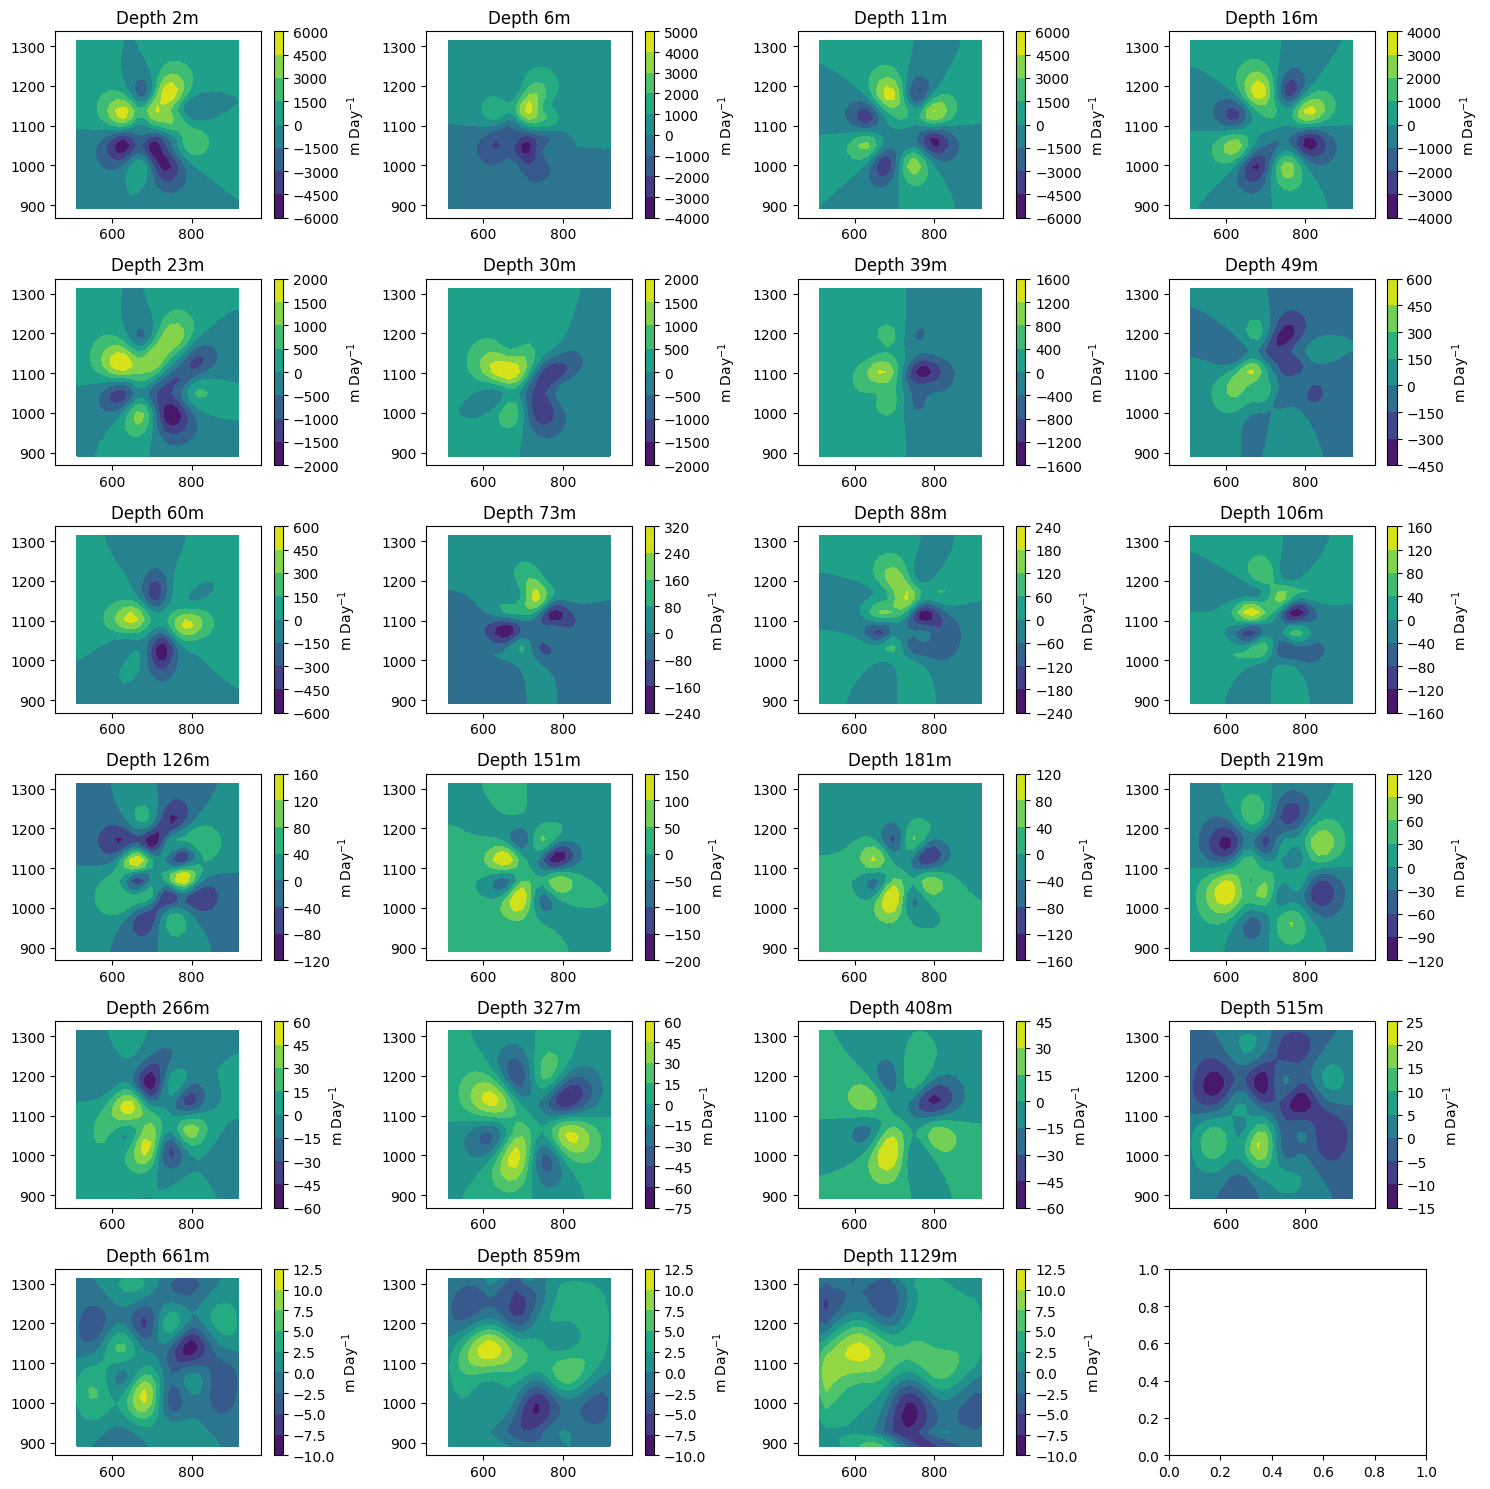

In [47]:
fig, axs = plt.subplots(6, 4, figsize=(15, 15))
for p in range(W.shape[-1]):
    ax = axs[p // 4, p % 4]
    cf = ax.contourf(xi, yi, W[:, :, p] * 86400 )
    ax.axis('equal')
    ax.set_title(f'Depth {round(zi[p])}m')
    fig.colorbar(cf, ax=ax, label=r'm Day$^{-1}$')
plt.tight_layout()
plt.show()


### $\sigma_{OW}$

In [ ]:
def calc_ow(uu, vv, dx, dy, flag=True):
    WIDTH, LENGTH, SIGMAS = uu.shape

    if flag:
        for k in range(SIGMAS):
            uu[:,:,k] = uu[:,:,k].T
            vv[:,:,k] = vv[:,:,k].T
    
    u_x = (uu[2:,:,:] - uu[:-2,:,:]) / (2*dx)
    u_y = (uu[:,2:,:] - uu[:,:-2,:]) / (2*dy)
    v_x = (vv[2:,:,:] - vv[:-2,:,:]) / (2*dx)
    v_y = (vv[:,2:,:] - vv[:,:-2,:]) / (2*dy)
    u_x = np.concatenate((np.zeros((1, LENGTH, SIGMAS)), u_x, np.zeros((1, LENGTH, SIGMAS))), axis=0)
    v_x = np.concatenate((np.zeros((1, LENGTH, SIGMAS)), v_x, np.zeros((1, LENGTH, SIGMAS))), axis=0)
    u_y = np.concatenate((np.zeros((WIDTH, 1, SIGMAS)), u_y, np.zeros((WIDTH, 1, SIGMAS))), axis=1)
    v_y = np.concatenate((np.zeros((WIDTH, 1, SIGMAS)), v_y, np.zeros((WIDTH, 1, SIGMAS))), axis=1)
    s_n = u_x - v_y
    s_s = v_x + u_y
    vort = v_x - u_y
    ow = s_n**2 + s_s**2 - vort**2
    return ow
    
def normalize_matrix(matrix, mask_value=np.nan):
    valid_mask = np.where(matrix == mask_value, 0, 1)
    valid_mean = np.nansum(matrix) / np.sum(valid_mask)
    valid_std = np.sqrt(np.nansum(valid_mask * (matrix - valid_mean) ** 2) / np.sum(valid_mask))
    return (matrix - valid_mean) / valid_std


In [ ]:
dx = np.diff(xi)[0]
dy = np.diff(yi)[0]

ow = calc_ow(U, V, dx*1000, dy*1000)
sigma_ow = normalize_matrix(ow)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage.measure import marching_cubes
from scipy.ndimage import map_coordinates

# ---- assume you already have ----
# sigma_ow : 3D numpy array of your scalar field
# Xg, Yg, Zg : 3D numpy arrays (same shape as sigma_ow)
# ---------------------------------

# 1. extract isosurface in index-space
verts, faces, normals, values = marching_cubes(sigma_ow, level=-0.2)

# 2. map each index‐space vertex into your real-world coords
#    verts is (Nverts, 3), columns = (i, j, k)
#    map_coordinates expects coordinates as (dim, Npoints)
pts = verts.T  # shape (3, Nverts)

# interpolate each coordinate array at those fractional indices
real_x = map_coordinates(Xg, pts, order=1)
real_y = map_coordinates(Yg, pts, order=1)
real_z = map_coordinates(Zg, pts, order=1)

# stack back into (Nverts, 3)
real_verts = np.vstack((real_x, real_y, real_z)).T

# 3. plot
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

mesh = Poly3DCollection(real_verts[faces], alpha=0.3)
mesh.set_edgecolor('k')
ax.add_collection3d(mesh)

# # optionally plot quiver of your velocity vectors (downsampled)
# step = 5
# ax.quiver(
#     Xg[::step,::step,::step],
#     Yg[::step,::step,::step],
#     Zg[::step,::step,::step],
#     U[::step,::step,::step],  # replace Ui, Vi, Wi with your vector components
#     V[::step,::step,::step],
#     W[::step,::step,::step],
#     length=10, normalize=True,  # adjust as needed
#     linewidths=0.5
# )

# 4. set axes limits to the extents of your grid
ax.set_xlim(Xg.min(), Xg.max())
ax.set_ylim(Yg.min(), Yg.max())
ax.set_zlim(Zg.min(), Zg.max())

# if you still want z inverted:
ax.invert_zaxis()

ax.set_xlabel('x (km)')
ax.set_ylabel('y (km)')
ax.set_zlabel('Depth (m)')

plt.tight_layout()
plt.show()



### Original

In [ ]:
break

In [ ]:
dic_orig = {}
for k in range(len(dic)):
    dic_orig[f'z{k}'] = {}
    dic_eddy_domain = extract_eddy_domain(eddy, t, dic_sample, df_eddies, mask_rho, X_grid, Y_grid, k=k)
    
    dic_orig[f'z{k}']['u'] = dic_eddy_domain['u']
    dic_orig[f'z{k}']['v'] = dic_eddy_domain['v']
    dic_orig[f'z{k}']['X'] = dic_eddy_domain['X']
    dic_orig[f'z{k}']['Y'] = dic_eddy_domain['Y']
    dic_orig[f'z{k}']['Depth'] = - dic_eddy_domain['Depth']

    # print(f'Eddy{eddy} t{t}')
    # print(df_Rce)

In [ ]:
import numpy as np
from scipy.interpolate import griddata

# 1) collect all (x,y,z) points and their u,v values
pts = []
uvals = []
vvals = []
for d in dic_orig.values():
    X = d['X'].ravel()
    Y = d['Y'].ravel()
    Z = d['Depth'] * np.ones_like(X)
    pts.append(np.column_stack((X, Y, Z)))
    uvals.append((d['u'] * scale_factor).ravel())
    vvals.append((d['v'] * scale_factor).ravel())

pts   = np.vstack(pts)
uvals = np.concatenate(uvals)
vvals = np.concatenate(vvals)

# 2) choose your new grid resolution
nz = len(dic_orig)
ny = max(d['X'].shape[0] for d in dic_orig.values()) // 5
nx = max(d['X'].shape[1] for d in dic_orig.values()) // 5

xi_orig = np.linspace(pts[:,0].min(), pts[:,0].max(), nx)
yi_orig = np.linspace(pts[:,1].min(), pts[:,1].max(), ny)
# zi = np.linspace(pts[:,2].min(), pts[:,2].max(), nz)
zi_orig = -z_r[:np.sort([int(a[1:]) for a in dic_orig.keys()]).max()+1]

Xg_orig, Yg_orig, Zg_orig = np.meshgrid(xi_orig, yi_orig, zi_orig, indexing='xy')
grid_pts   = np.column_stack((Xg_orig.ravel(), Yg_orig.ravel(), Zg_orig.ravel()))

# 3) interpolate onto the cube
U_orig = griddata(pts, uvals, grid_pts, method='linear', fill_value=0)
V_orig = griddata(pts, vvals, grid_pts, method='linear', fill_value=0)
# W = np.zeros_like(U)

# 4) reshape back to 3D
U_orig = U_orig.reshape(Xg_orig.shape)
V_orig = V_orig.reshape(Xg_orig.shape)
# W = W.reshape(Xg.shape)


In [ ]:
dx_orig = np.diff(xi_orig)[0]
dy_orig = np.diff(yi_orig)[0]

ow_orig = calc_ow(U_orig, V_orig, dx_orig*1000, dy_orig*1000, flag=False)
sigma_ow_orig = normalize_matrix(ow_orig)


In [ ]:
# ---- assume you already have ----
# sigma_ow : 3D numpy array of your scalar field
# Xg, Yg, Zg : 3D numpy arrays (same shape as sigma_ow)
# ---------------------------------

# 1. extract isosurface in index-space
verts, faces, normals, values = marching_cubes(sigma_ow_orig, level=-0.2)

# 2. map each index‐space vertex into your real-world coords
#    verts is (Nverts, 3), columns = (i, j, k)
#    map_coordinates expects coordinates as (dim, Npoints)
pts = verts.T  # shape (3, Nverts)

# interpolate each coordinate array at those fractional indices
real_x = map_coordinates(Xg_orig, pts, order=1)
real_y = map_coordinates(Yg_orig, pts, order=1)
real_z = map_coordinates(Zg_orig, pts, order=1)

# stack back into (Nverts, 3)
real_verts = np.vstack((real_x, real_y, real_z)).T

# 3. plot
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

mesh = Poly3DCollection(real_verts[faces], alpha=0.3)
mesh.set_edgecolor('k')
ax.add_collection3d(mesh)

# # optionally plot quiver of your velocity vectors (downsampled)
# step = 5
# ax.quiver(
#     Xg[::step,::step,::step],
#     Yg[::step,::step,::step],
#     Zg[::step,::step,::step],
#     U[::step,::step,::step],  # replace Ui, Vi, Wi with your vector components
#     V[::step,::step,::step],
#     W[::step,::step,::step],
#     length=10, normalize=True,  # adjust as needed
#     linewidths=0.5
# )

# 4. set axes limits to the extents of your grid
ax.set_xlim(Xg_orig.min(), Xg_orig.max())
ax.set_ylim(Yg_orig.min(), Yg_orig.max())
ax.set_zlim(Zg_orig.min(), Zg_orig.max())

# if you still want z inverted:
ax.invert_zaxis()

ax.set_xlabel('x (km)')
ax.set_ylabel('y (km)')
ax.set_zlabel('Depth (m)')

ax.view_init(elev=30, azim=10)
plt.tight_layout()
plt.show()



In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

spacing = 10
scale_factor = 10  # adjust arrow length

for key in dic_orig:
    d = dic_orig[key]
    XX = d['X'][::spacing, ::spacing]
    YY = d['Y'][::spacing, ::spacing]
    ZZ = d['Depth']
    UU = d['u'][::spacing, ::spacing] * scale_factor
    VV = d['v'][::spacing, ::spacing] * scale_factor
    WW = np.zeros_like(UU)

    ax.quiver(XX, YY, ZZ, UU, VV, WW, length=scale_factor)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Depth')
ax.invert_zaxis()
intt = 100
ax.set_xlim(650-intt, 800+intt)
ax.set_ylim(1050-intt, 1150+intt)
ax.view_init(elev=20, azim=120)

plt.show()